In [296]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn
import argparse
import imf

import NT_disk_Eqns_V1 as jscript
import binary_formation_distribution_V8 as myscript
import binary_formation_distribution_V11 as myscript2

from scipy.interpolate import UnivariateSpline

from os import makedirs
import os

import pandas as pd
import matplotlib.patches as patch

import powerlaw
import random

import Novikov
import Thompson_edited as edit
from scipy.interpolate import interp1d
from pagn.opacities import electron_scattering_opacity
#scontinuing on from disk_profiles.ipynb to generalise to some rate calculations

In [300]:
def T_align(disk, Mbh, mbh, cos_i, H, R):
    i=np.arccos(cos_i)
    cos_i2=np.cos(i/2)
    sin_i2=np.sin(i/2)
    t_orb=2*np.pi*(R)**(2/3) * (ct.G * Mbh)**(-1/2)
    t_align= (t_orb * Mbh**2)/(2*mbh*disk.Mdisk) * cos_i2 * (sin_i2**2 + H/(4*R))**2
    return t_align

def cluster_df(cluster, R, cos_i, disk):
    # print(f'cluster:{cluster}\n R:{R}\n cosi:{cos_i}\n disk:{disk}')
    Mbh=disk.Mbh

    R_g=Mbh * ct.G /(ct.c*ct.c)

    d = {"mbh [Msun]": cluster, 'r [Rg]': R/R_g, 'cos_i': cos_i}
    df=pd.DataFrame(data=d)

    f=interp1d(disk.R, disk.h, kind='linear', fill_value='extrapolate')
    h_clust=f(df['r [Rg]'] * R_g)

    df["H/R"]=h_clust/(df['r [Rg]'] * R_g)
    df['H']=h_clust

    mbh=df['mbh [Msun]']*ct.MSun

    i=np.arccos(cos_i)
    cos_i2=np.cos(i/2)
    sin_i2=np.sin(i/2)

    t_orb=2*np.pi*(df['r [Rg]'] * R_g)**(2/3) * (ct.G * Mbh)**(-1/2)
    # t_align= (t_orb * Mbh**2)/(2*mbh*disk.Mdisk) * cos_i2 * (sin_i2**2 + df['H']/(4*df['r [Rg]']*R_g))**2
    t_align=T_align(disk, Mbh, mbh, df['cos_i'], df['H'], df['r [Rg]'])

    df['t_align [yrs]']=t_align/(365*24*60*60)

    p=1-np.exp((-(1e7*365*24*60*60)/(t_align)))
    df['p_align']=p

    return df

def cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, save):

    Mbh=Mbh=MBH_digit * 10**MBH_power * ct.MSun

    Ledd=jscript.Ledd(Mbh, X=0.7)
    Mdot_edd = Ledd / (eps*ct.c ** 2)
    Mdot = le * Mdot_edd

    # mdot=Mdot/Mdot_edd
    # print(mdot)

    if DT=="SG":
        disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
        # disk = pagn.SirkoAGN(Mbh=Mbh)
        Rmin = disk.Rmin
        Rmax = disk.Rmax
        disk.solve_disk()

    R_g=Mbh * ct.G /(ct.c*ct.c)

    Rmax=0.1 * jscript.pc * (Mbh/(1e6 * ct.MSun))**(1/2)

    cluster=[]
    cluster_mass=2 * Mbh/ct.MSun

    if BIMF=='Tagawa':
    #Tagawa et al 2020 BIMF
        cluster_tagawa = imf.make_cluster(cluster_mass, massfunc='salpeter', alpha=2.3, mmin=0.1, mmax=140)
        for mass in cluster_tagawa:
            if mass<20:
                continue
            elif 20<=mass<40:
                mass_bh=mass/4
            elif 40<=mass<=55:
                mass_bh=10
            elif 55<=mass<=120:
                mass_bh=mass/13 + 5.77
            else:
                mass_bh=15
            cluster.append(mass_bh)
        bh_mass_tot=np.sum(cluster)
        print(f'Total bh mass is {bh_mass_tot}')

    elif BIMF=='Bartos':
    #Bartos et al 2017 BIMF
        bartos_cluster=imf.make_cluster(0.04*cluster_mass, massfunc='salpeter', alpha=2, mmin=5, mmax=50)
        cluster=bartos_cluster
        print(f'Total bh mass is {np.sum(cluster)}')

    elif BIMF=='Vaccaro':
    #Actually from Iorio et al 2023, but file provided by MP Vaccaro
        mass_tot=0
        mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
        while mass_tot<0.04*cluster_mass:
            c = np.random.randint(0, len(mass_sec))
            cluster.append(mass_sec[c])
            mass_tot+=mass_sec[c]
        print(f'Total bh mass is {np.sum(cluster)}')

    a=powerlaw.Power_Law(alpha=2.5, xmin=12*R_g, xmax=Rmax)
        # print(np.max(a.rvs(len(iorio_bhs))))
    R=a.generate_random(len(cluster))

    cos_i=np.random.uniform(-1.0, 1.0, len(cluster))
    df=cluster_df(cluster, R, cos_i, disk)

    if save==True:
        df.to_csv(f'EMRI_Rates/{BIMF}/dataframes/{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.csv')
    return df

def plot_cluster(df, MBH_digit, MBH_power, alpha, eps, le, spin, BIMF, t_agn, DT, save=False):
    plt.figure(figsize=(6, 8))
    plt.scatter(df['r [Rg]'], df['mbh [Msun]'], c=df['t_align [yrs]']/t_agn, cmap='gist_rainbow', norm='log')
    plt.xscale('log')
    plt.colorbar(label="$t_{align}/t_{AGN}$", orientation="horizontal")
    # plt.clim(0,1)
    plt.xscale('log')
    plt.xlabel(r'$R~[R_g]$')
    plt.ylabel(r'$mbh~[M_{\odot}]$')
    plt.title('$t_{align}/t_{AGN},~$' f'SMBH={MBH_digit}e{MBH_power}'r'$M_{\odot}, ~\alpha$' f'$={alpha},~e={eps},~l_e={le},~X={spin}$')
    if save==True:
        plt.savefig(f'EMRI_Rates/{BIMF}/t_align_{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.png')
    plt.show()

    plt.figure(figsize=(6, 8))
    plt.scatter(df['r [Rg]'], df['mbh [Msun]'], c=df['p_align'], cmap='gist_rainbow')
    plt.xscale('log')
    plt.colorbar(label="$p_{align}$", orientation="horizontal")
    plt.clim(0,1)
    plt.xscale('log')
    plt.xlabel(r'$R~[R_g]$')
    plt.ylabel(r'$mbh~[M_{\odot}]$')
    plt.title('$p_{align},~$' f'SMBH={MBH_digit}e{MBH_power}'r'$M_{\odot}, ~\alpha$' f'$={alpha},~e={eps},~l_e={le},~X={spin}$')
    if save==True:
        plt.savefig(f'EMRI_Rates/{BIMF}/p_align_{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.png')
    plt.show()


1e4 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total cluster mass is 19999.9 (limit was 20000)
Total bh mass is 472.25683332975757


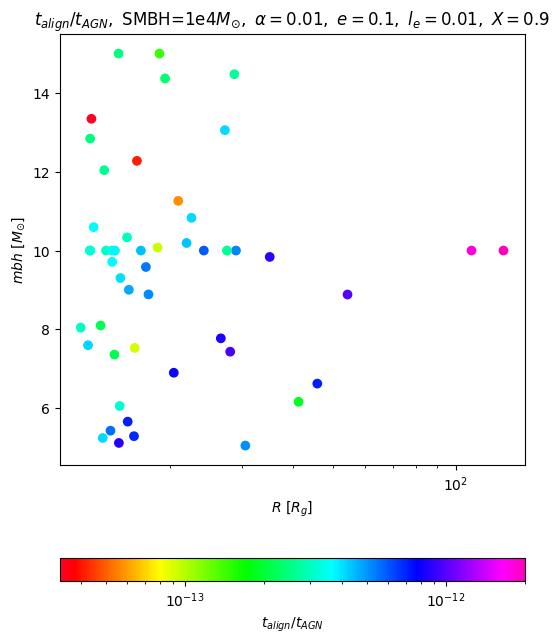

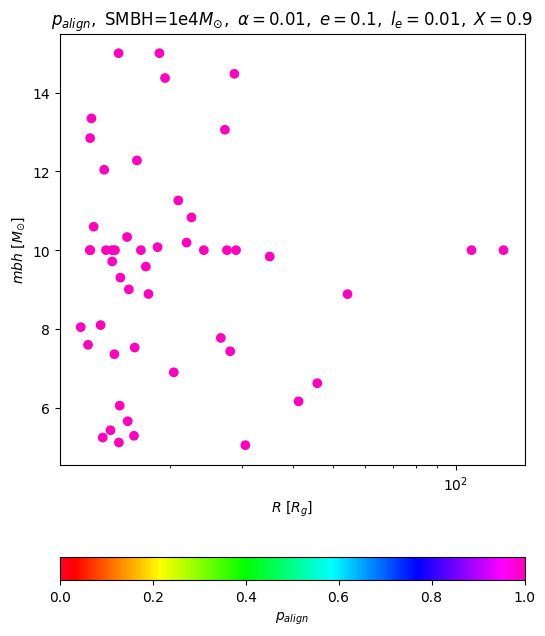

1e4 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total cluster mass is 798.727 (limit was 800)
Total bh mass is 798.7266880355196


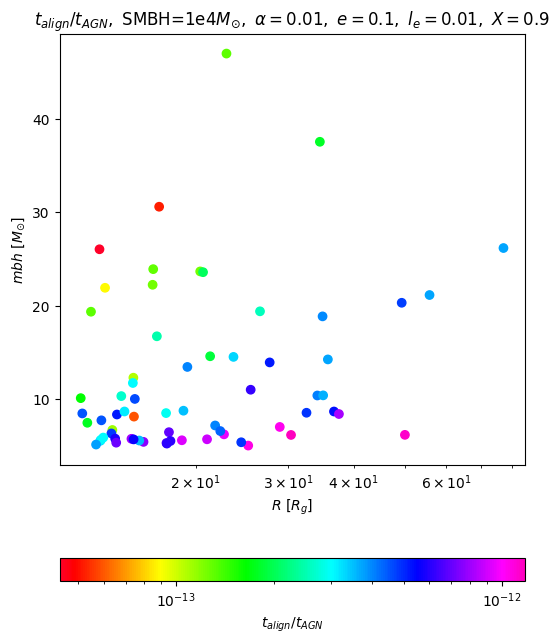

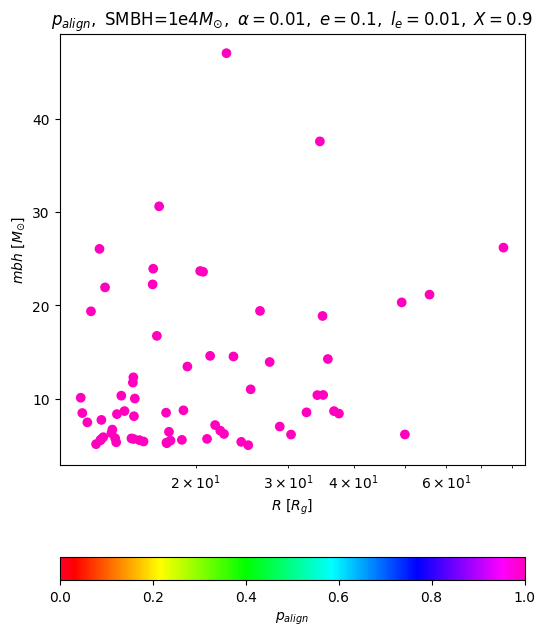

1e4 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total bh mass is 814.1895902095001


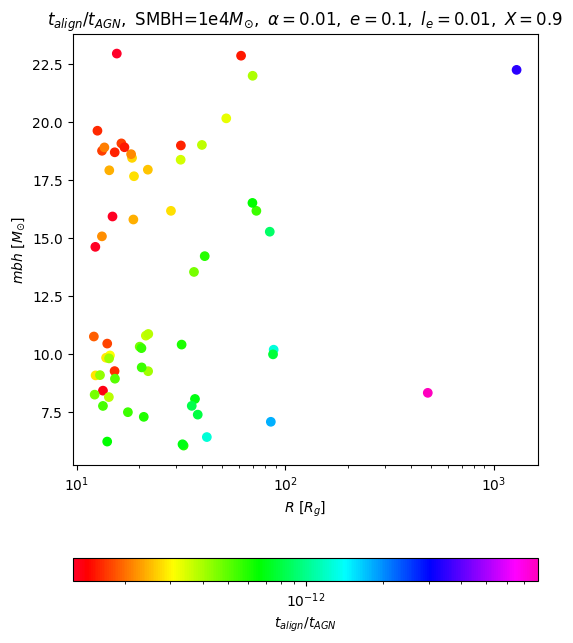

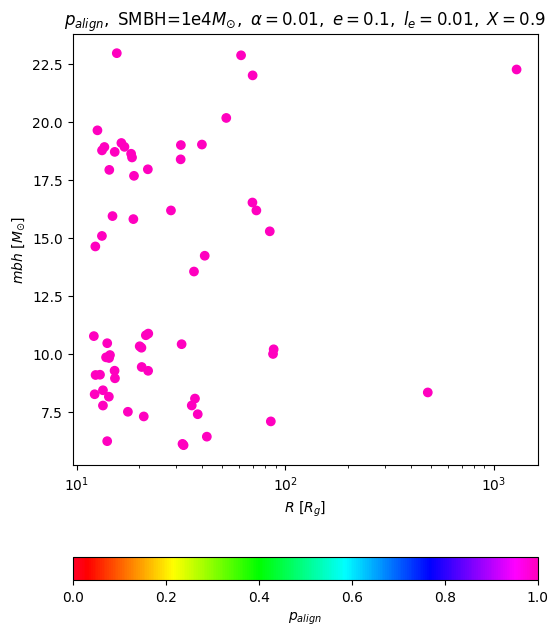

1e4 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total cluster mass is 20000 (limit was 20000)
Total bh mass is 448.764200045465


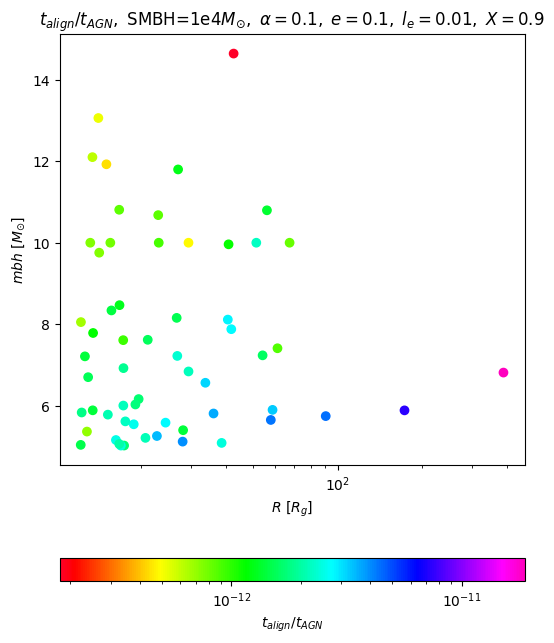

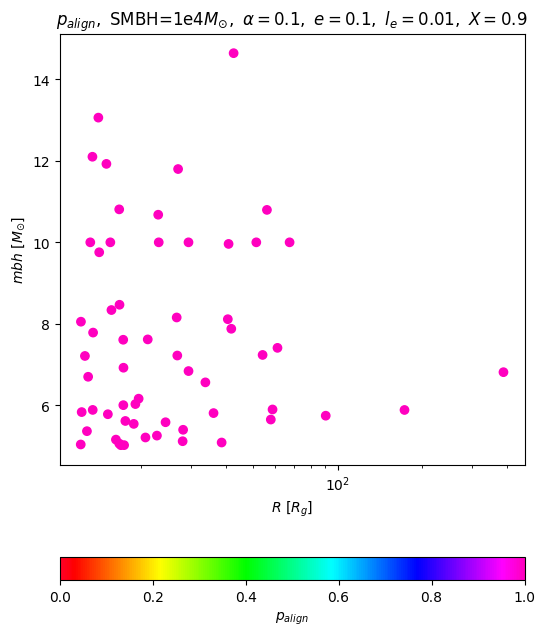

1e4 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total cluster mass is 798.381 (limit was 800)
Total bh mass is 798.3809485524239


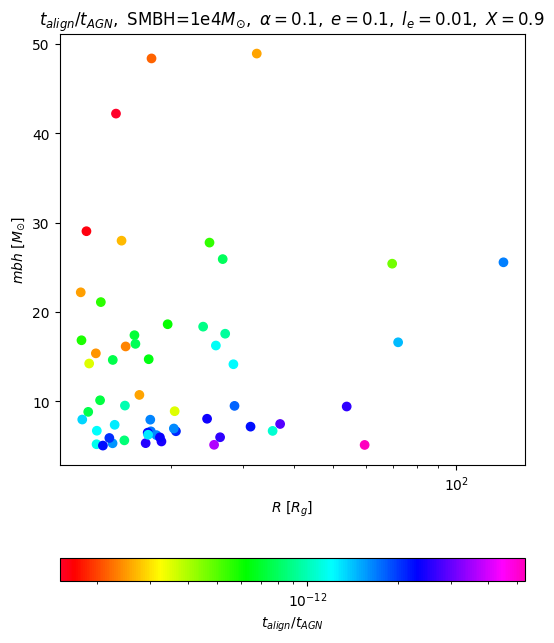

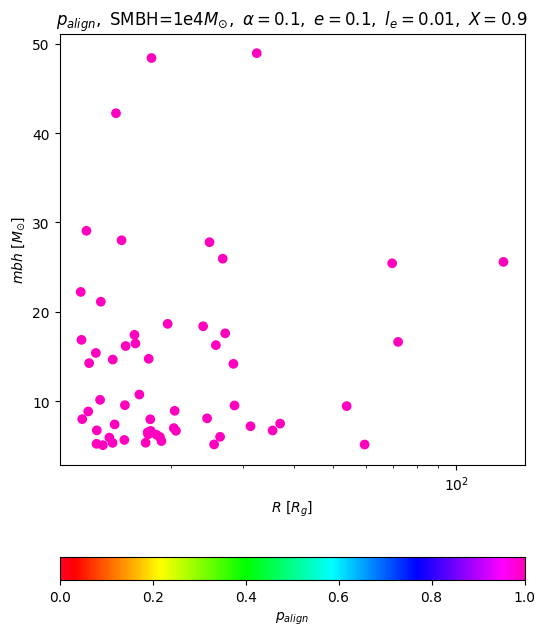

1e4 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total bh mass is 812.2581567645001


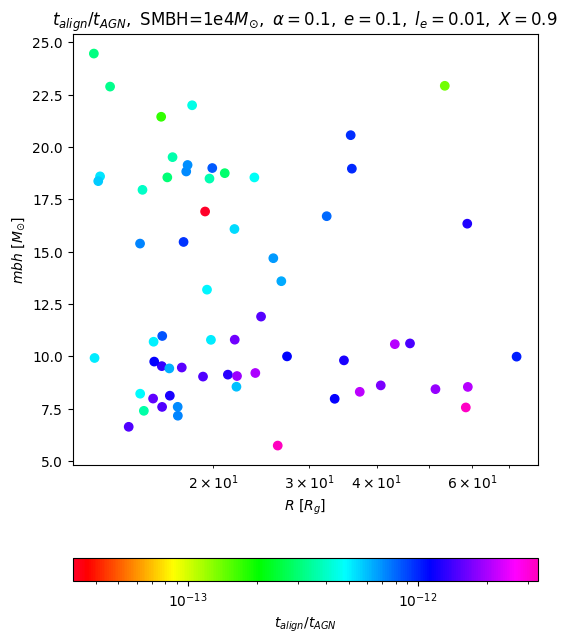

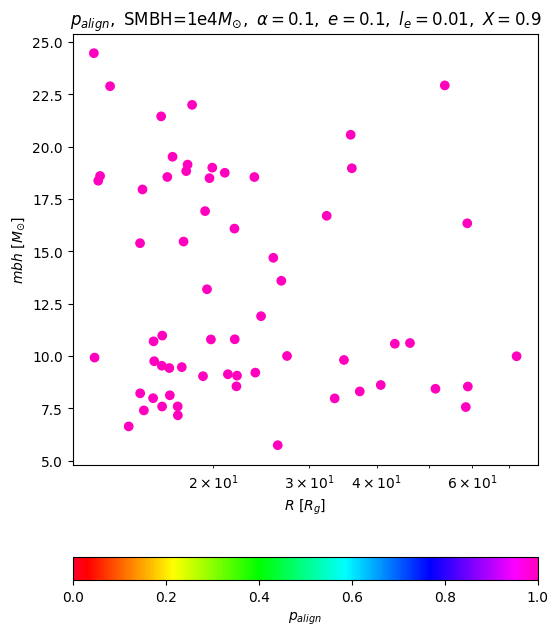

1e5 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total cluster mass is 200000 (limit was 200000)
Total bh mass is 4056.3278066820326


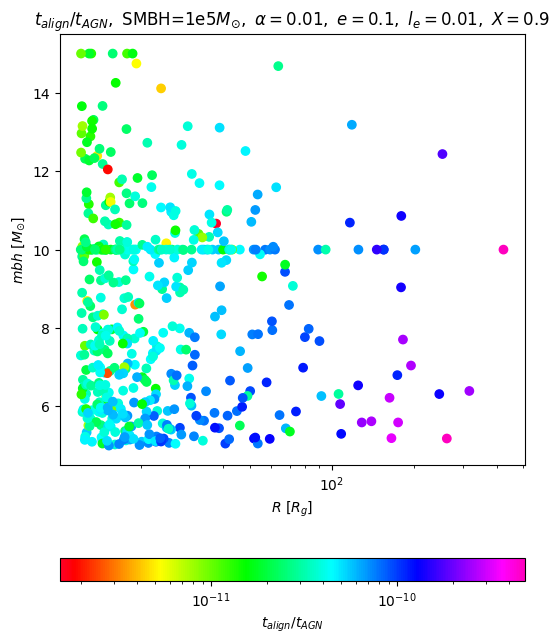

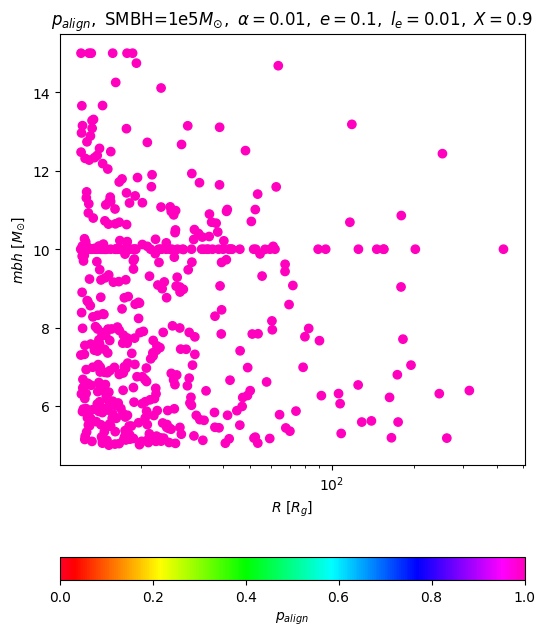

1e5 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total cluster mass is 7987.51 (limit was 8000)
Total bh mass is 7987.509956630036


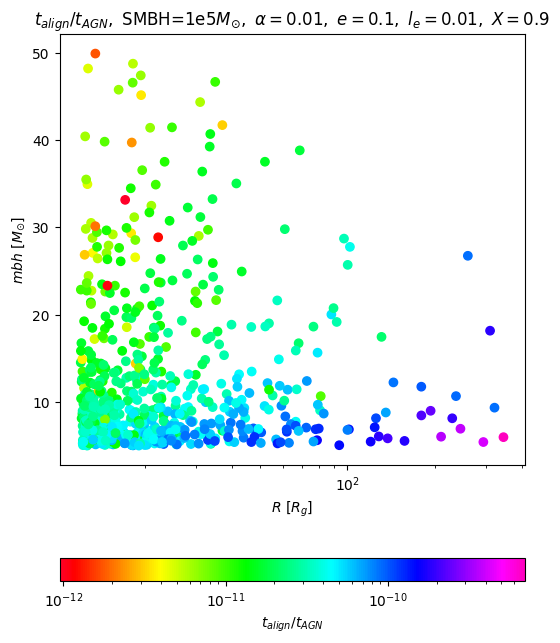

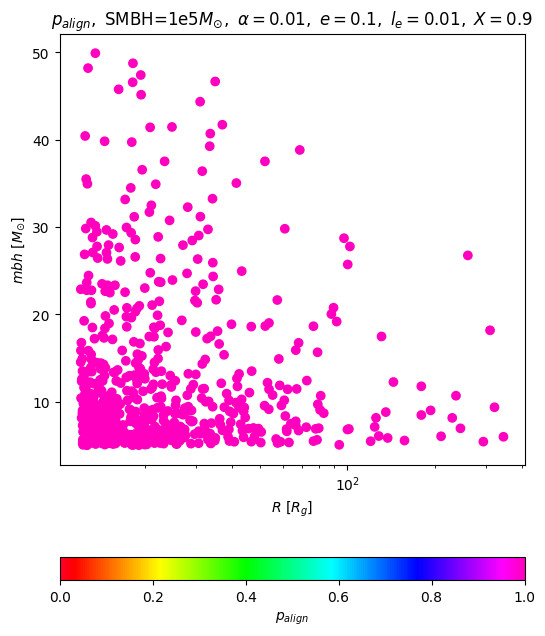

1e5 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total bh mass is 8001.4907957162995


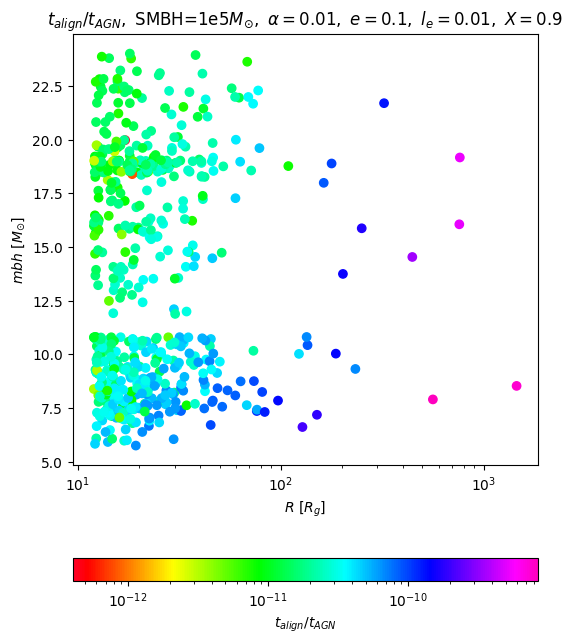

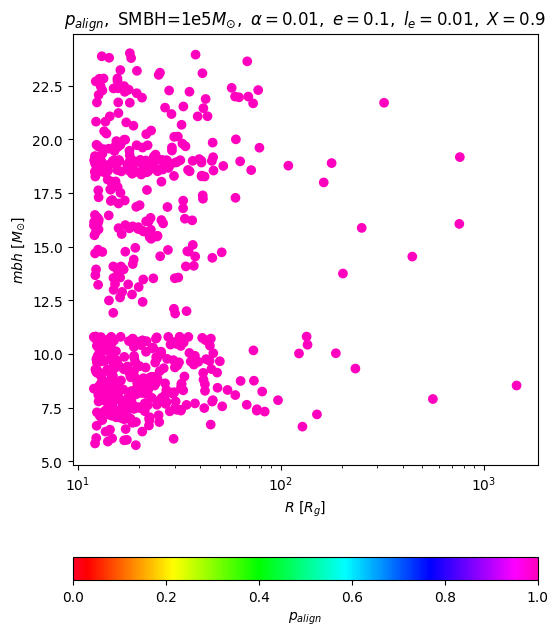

1e5 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total cluster mass is 199997 (limit was 200000)
Total bh mass is 3865.1029210406978


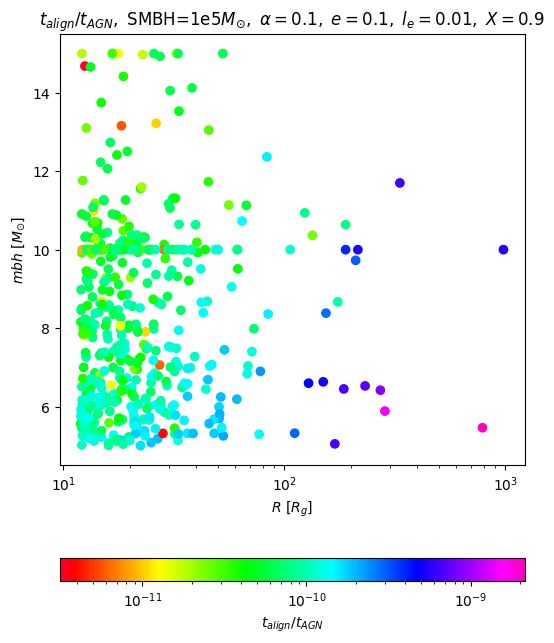

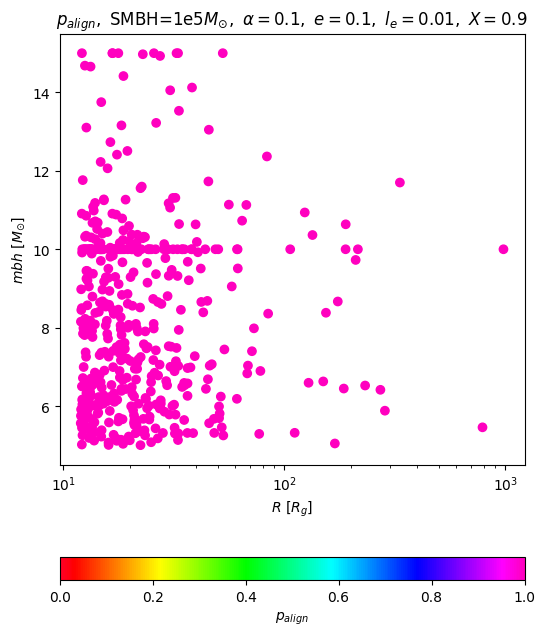

1e5 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total cluster mass is 7996.01 (limit was 8000)
Total bh mass is 7996.006560067087


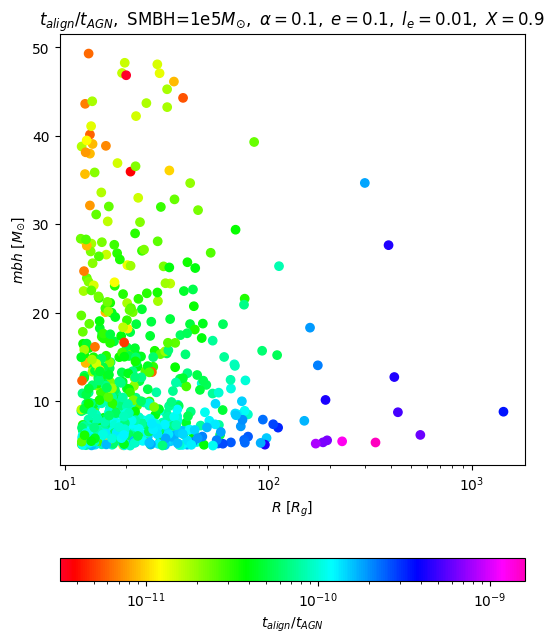

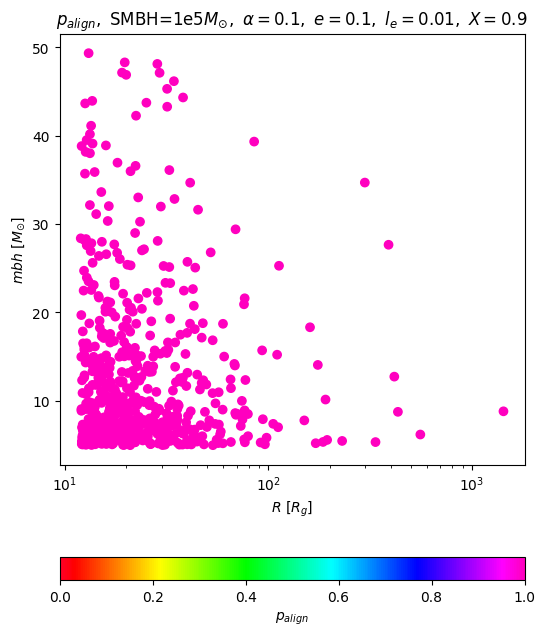

1e5 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total bh mass is 8000.1952571081


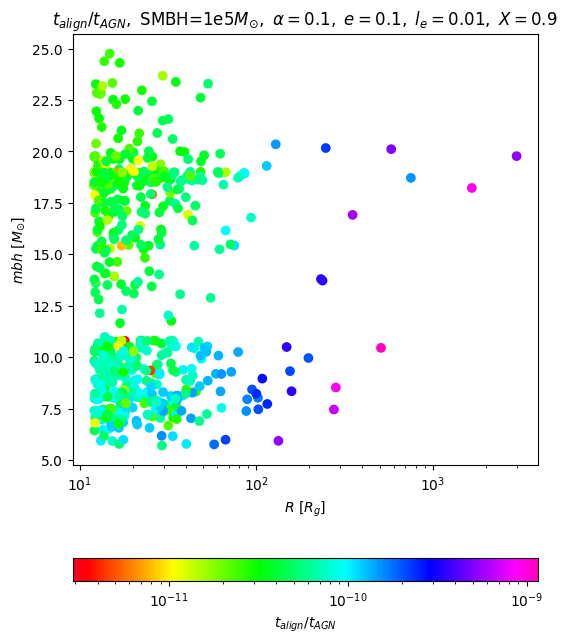

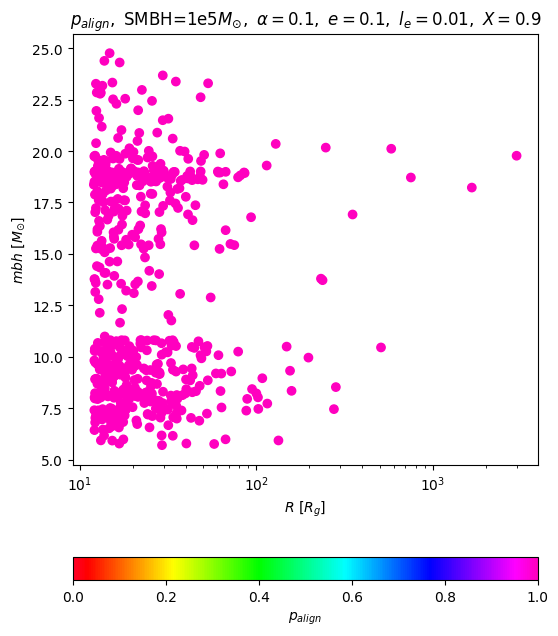

1e6 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total cluster mass is 2e+06 (limit was 2e+06)
Total bh mass is 41004.424477329725


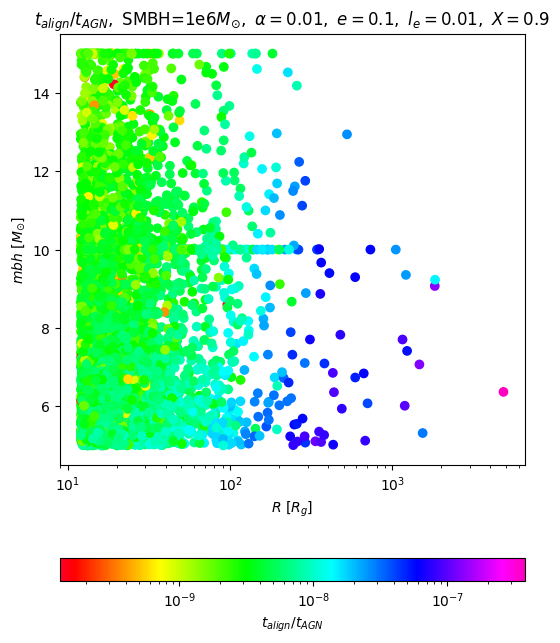

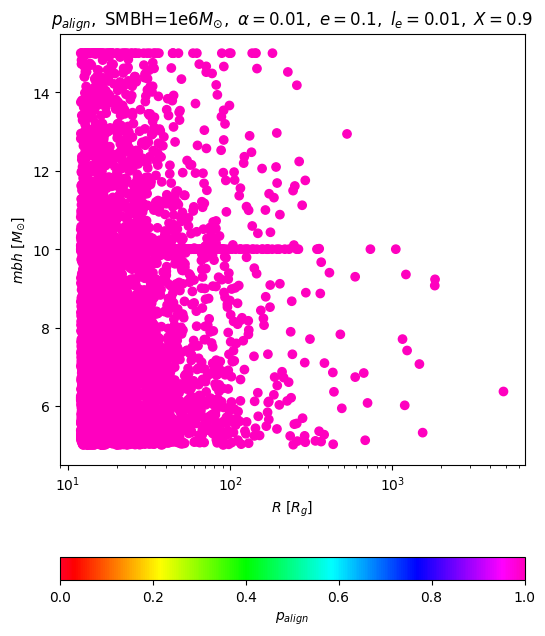

1e6 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total cluster mass is 80001.4 (limit was 80000)
Total bh mass is 80001.42424584206


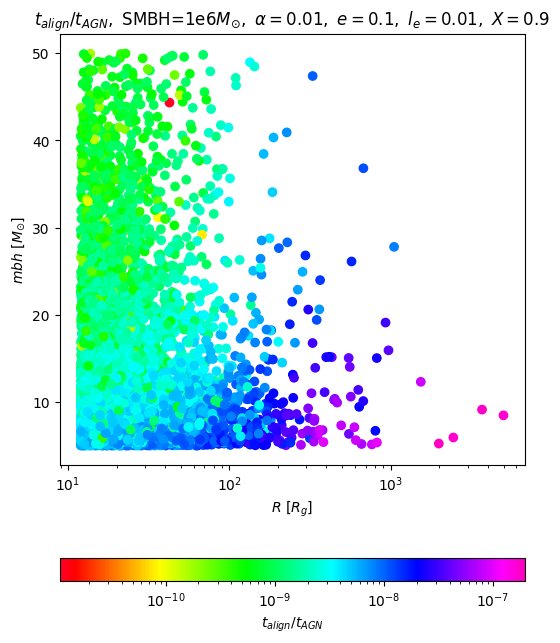

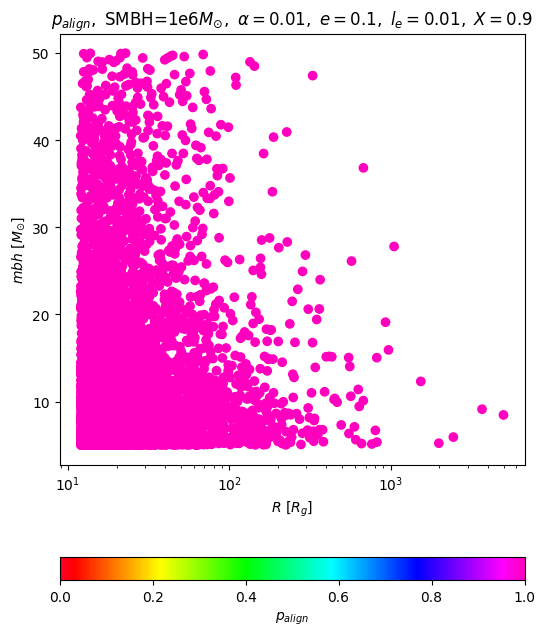

1e6 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total bh mass is 80006.3708467585


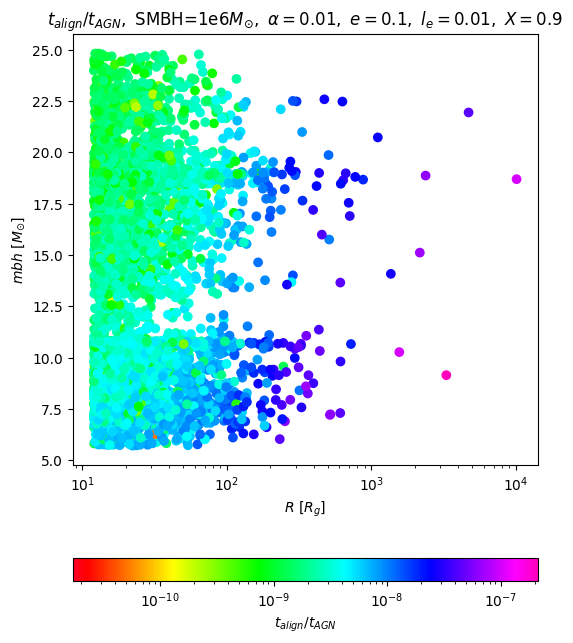

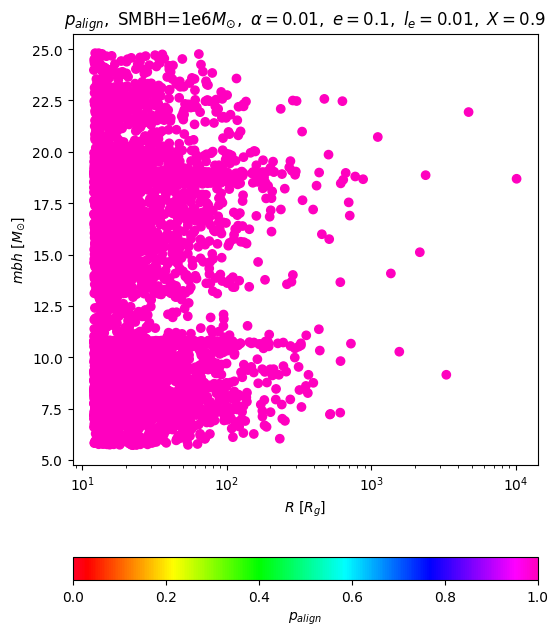

1e6 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total cluster mass is 2e+06 (limit was 2e+06)
Total bh mass is 42016.462434809975


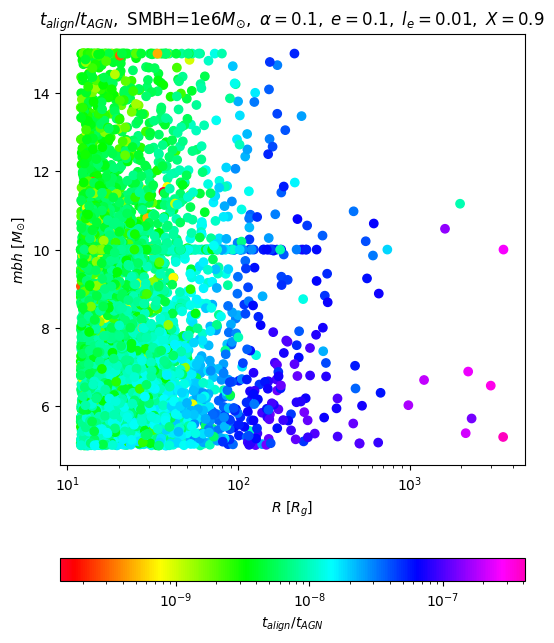

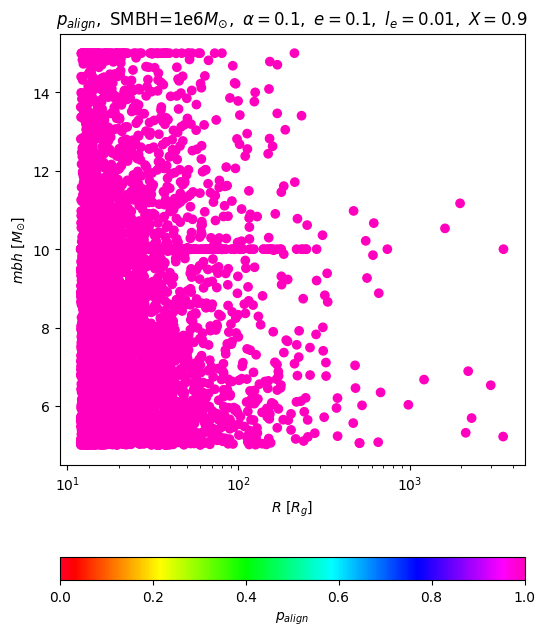

1e6 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total cluster mass is 79993.2 (limit was 80000)
Total bh mass is 79993.24149120576


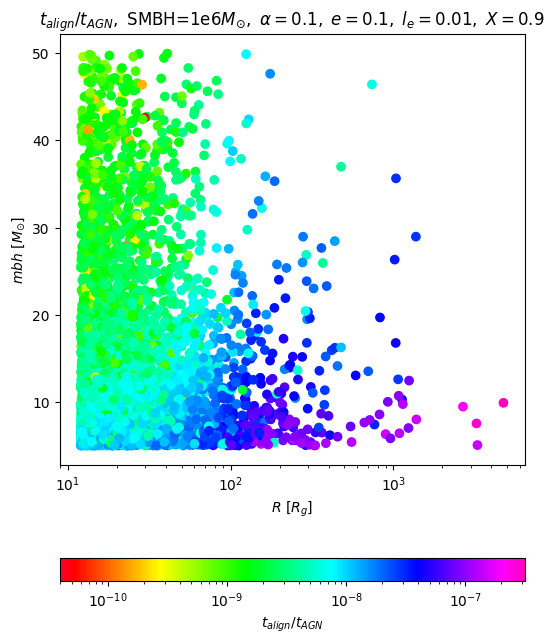

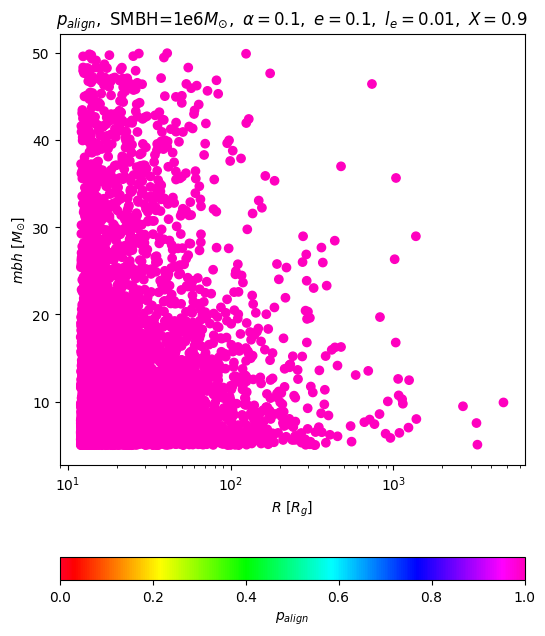

1e6 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total bh mass is 80015.0640923437


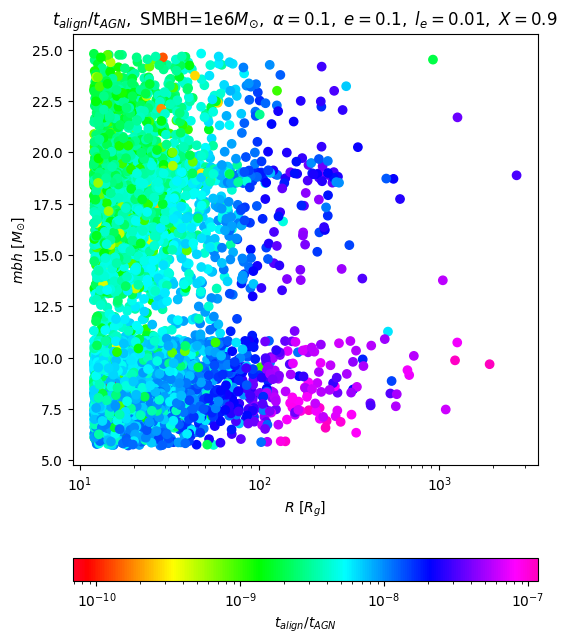

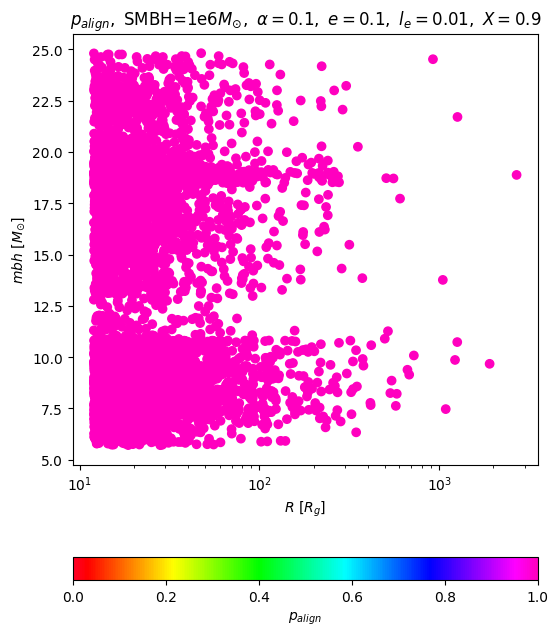

1e7 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total cluster mass is 2e+07 (limit was 2e+07)
Total bh mass is 413621.89474026946


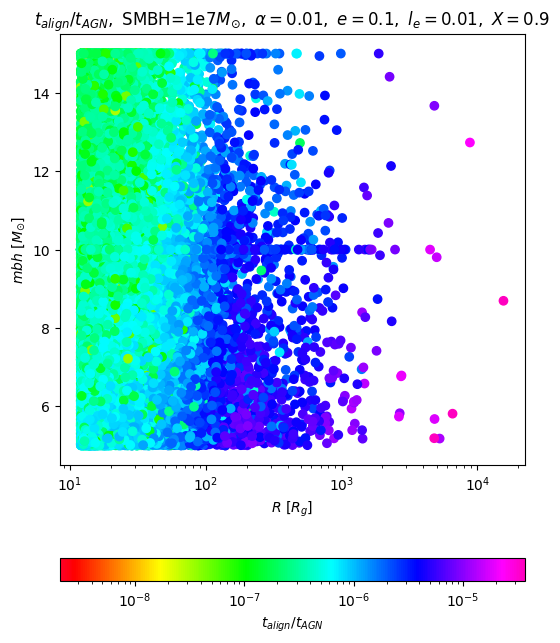

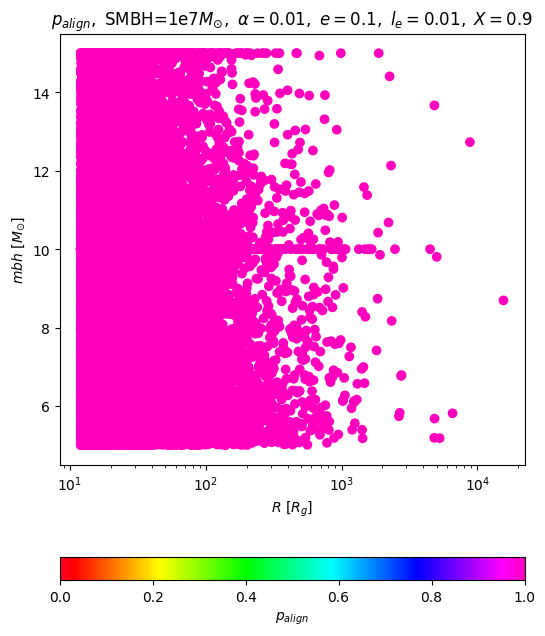

1e7 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total cluster mass is 800005 (limit was 800000)
Total bh mass is 800005.331892171


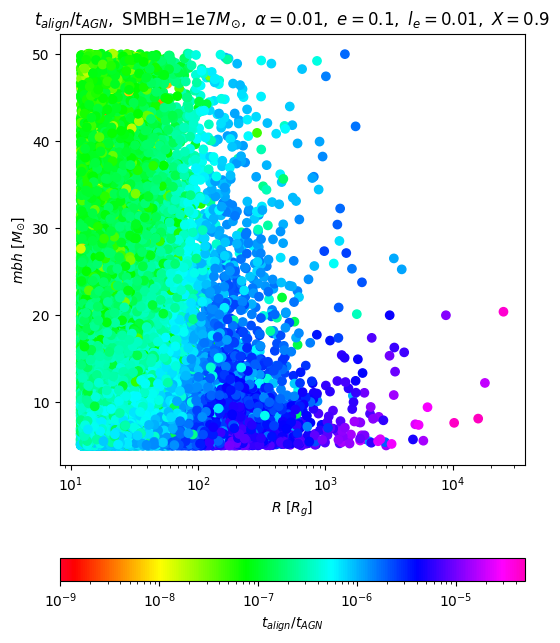

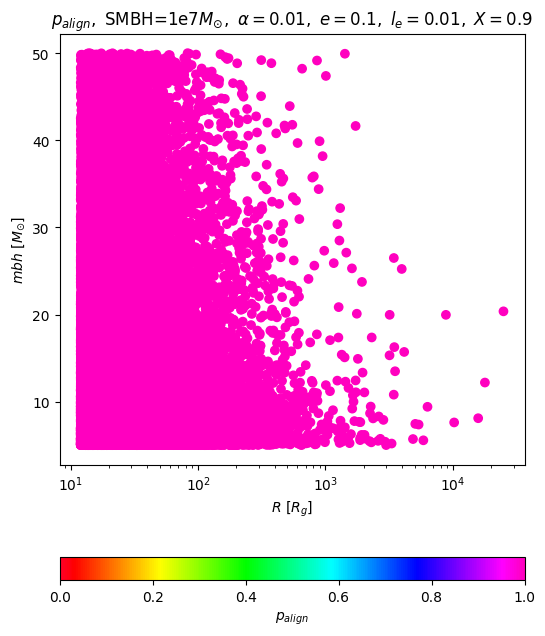

1e7 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total bh mass is 800001.8583158831


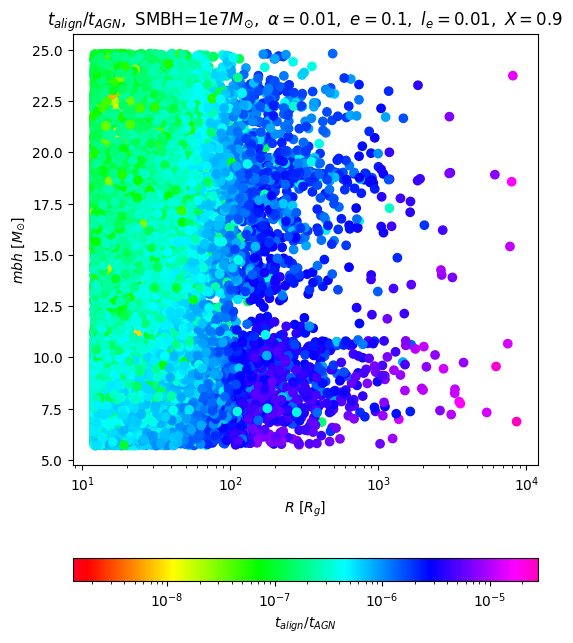

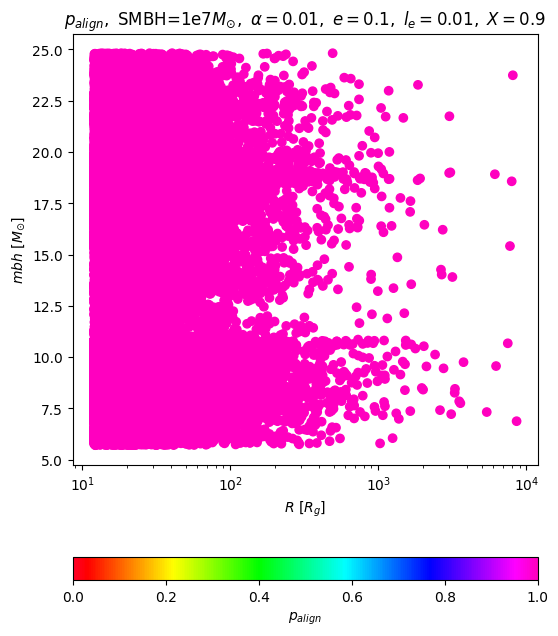

1e7 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total cluster mass is 2e+07 (limit was 2e+07)
Total bh mass is 409869.0561100922


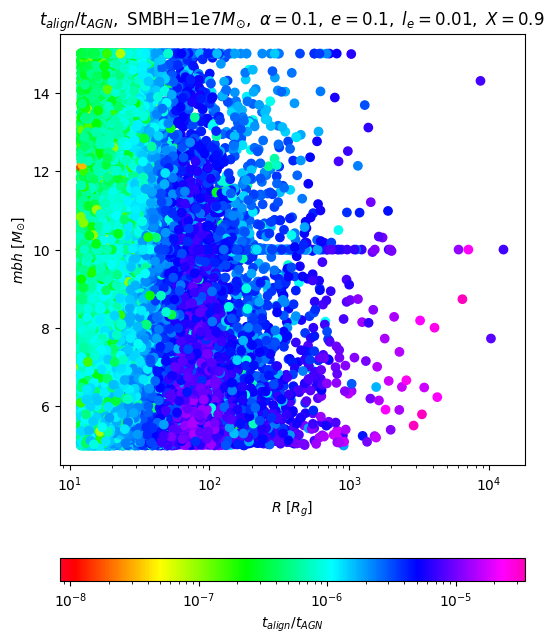

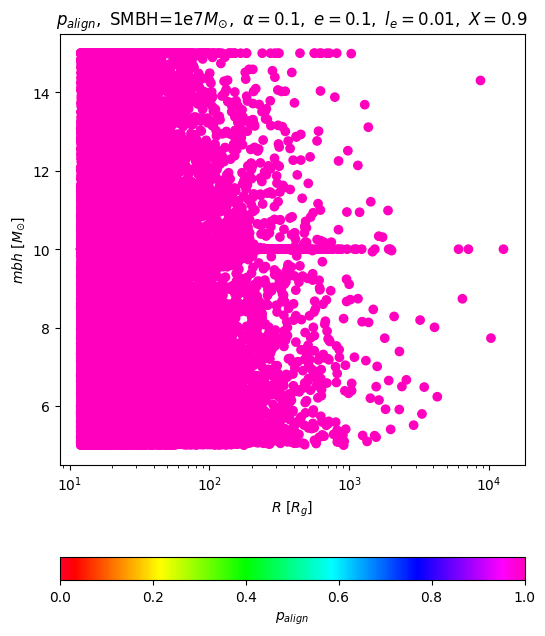

1e7 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total cluster mass is 800000 (limit was 800000)
Total bh mass is 800000.1083295982


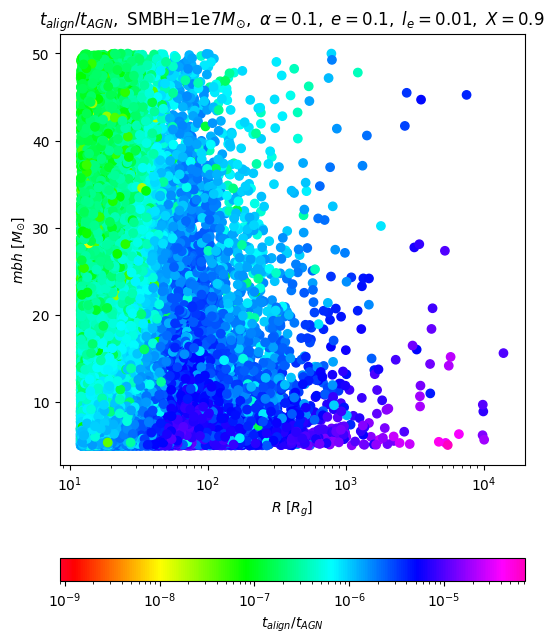

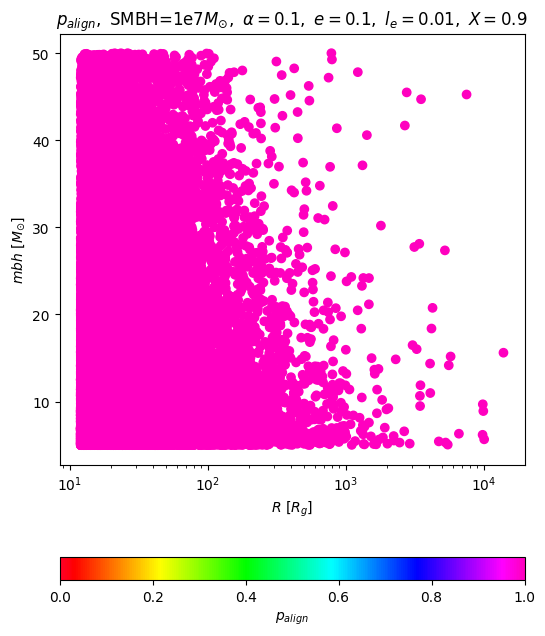

1e7 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total bh mass is 800009.170233025


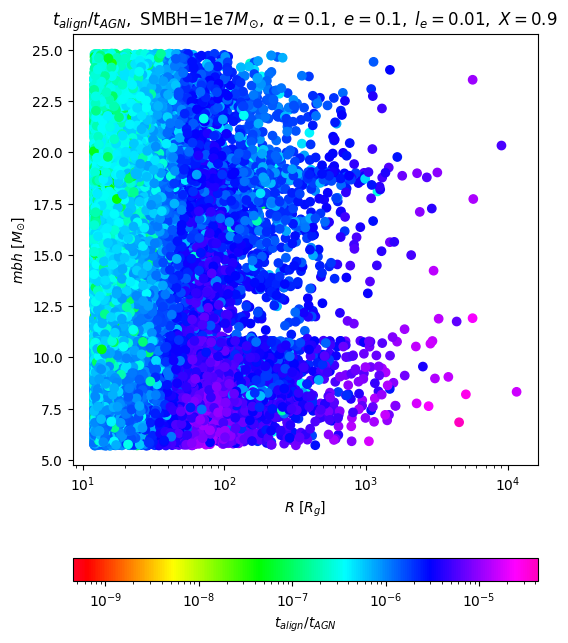

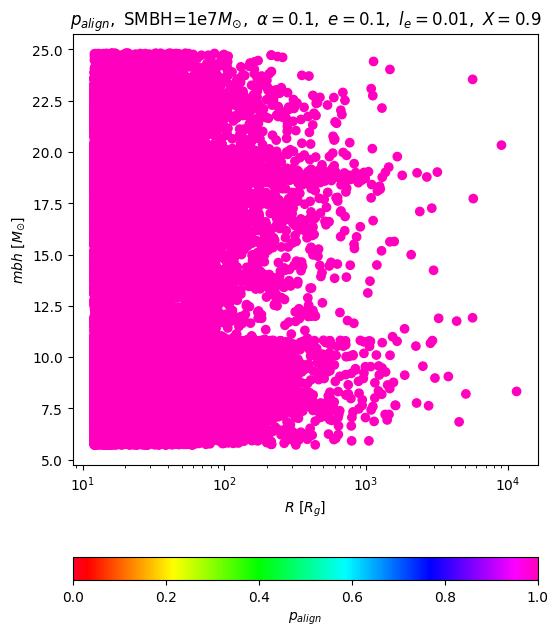

In [ ]:
powers = 4,5,6,7
alphas = 0.01, 0.1
BIMFs='Tagawa', 'Bartos', 'Vaccaro'

spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7
MBH_digit=1

TT='G23'
DT='SG'

for MBH_power in powers:
    for alpha in alphas:
        for BIMF in BIMFs:
            print(f'{MBH_digit}e{MBH_power} MSun, alpha {alpha}, BIMF {BIMF}')
            df=cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, True)
            plot_cluster(df, MBH_digit, MBH_power, alpha, eps, le, spin, BIMF, t_agn, DT, save=True)


In [ ]:
MBH_power=8
MBH_digit=1
spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7

TT='G23'
DT='SG'
BIMF='Tagawa'

df=cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, False)

AttributeError: module 'binary_formation_distribution_V11' has no attribute 'cluster_sampling'

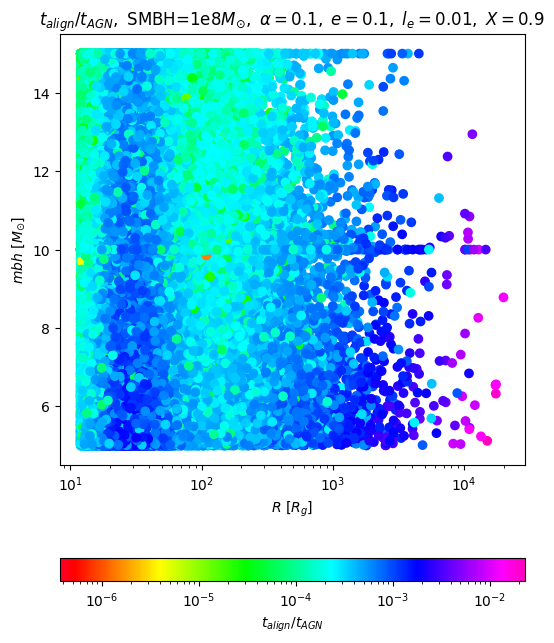

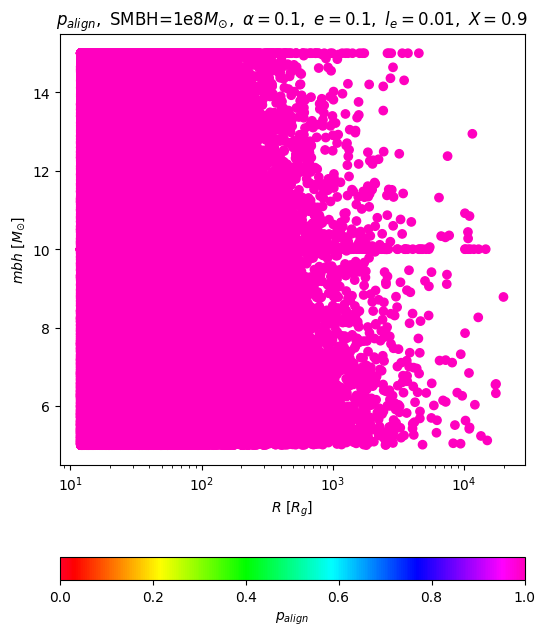

In [229]:
masses=np.linspace(5, 15, 100)
radii=np.logspace(1, 4, base=10)
cos_is=np.linspace(-1, 1, 100)

MBH_power=6
MBH_digit=4

Mbh=Mbh=MBH_digit * 10**MBH_power * ct.MSun

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot_edd = Ledd / (eps*ct.c ** 2)
Mdot = le * Mdot_edd

# disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
disk = pagn.SirkoAGN(Mbh=Mbh)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

t_agn=10**7

R_g=Mbh * ct.G /(ct.c*ct.c)

f=interp1d(disk.R, disk.h, kind='linear', fill_value='extrapolate')

Ms=[]
Rs=[]
f_aligns=[]

for m in masses:
    mbh=m*ct.MSun
    for r in radii:
        R=r*R_g
        probs=[]
        for cosi in cos_is:
            h_clust=f(R)
            t_align= T_align(disk, Mbh, mbh, cosi, h_clust, R)
            p=1-np.exp((-(t_agn)/(t_align*60*60*24*365)))
            probs.append(p)
        f_align=np.sum(probs)/len(cos_is)
        Ms.append(m)
        Rs.append(r)
        f_aligns.append(f_align)
        
        # print(f'mass: {m}, R: {r} Rg, f_align: {f_align}')



### Sirko & Goodman 2003 parameters ###
Mbh = 4.000000e+06 MSun
Mdot = 5.193378e-02 MSun/yr
le = 0.5
Rs = 3.828048e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 3.828048e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4948 (R=7.20e+03 Rs)
Beginning star formation at index 4948
Mdisk = 4534493.725748573 Msun
Mdisk/Mbh = 1.1336234314371434


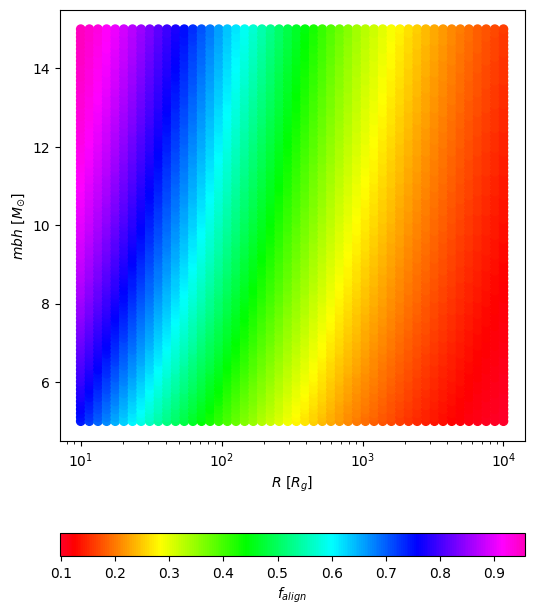

In [231]:
plt.figure(figsize=(6, 8))
plt.scatter(Rs, Ms, c=f_aligns, cmap='gist_rainbow')
plt.xscale('log')
plt.colorbar(label="$f_{align}$", orientation="horizontal")
# plt.clim(0,1)

plt.xlabel(r'$R~[R_g]$')
plt.ylabel(r'$mbh~[M_{\odot}$]')

plt.show()